In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats as st
import seaborn as sns
from math import sqrt
from IPython.display import Latex,display,Math
print("Modules Imported!")


Modules Imported!


# Steady-state distributions of Markov chains

In this excercise, let 

$$P=\left[\begin{array}{cccc}
\text{}  & \text{W} & \text{S}\\
\text{W} & \frac{1}{2} & \frac{1}{2}\\
\text{S} &\frac{1}{3} & \frac{2}{3}
\end{array}\right]$$
denote the transition matrix of a Markov chain process $X_n$ with two states $\{W,S\}$. For example, $Pr(X_n=W|X_{n-1}=S)=\frac13$. Recall that if $\pi^{(n)}$ denotes the distribution of $X_n$, we have $\pi^{(n+1)}=\pi^{(n)}P$. Note that $X_n$ is [irreducible and aperiodic](https://en.wikipedia.org/wiki/Markov_chain#Properties). So it has a unique steady state distribution $\phi$, which corresponds to the left eigenvector for eigenvalue 1.

_____________
### Q1: Steady-state distribution $\phi$
**(1 point)** Use [`numpy.linalg.eig`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html#numpy.linalg.eig) to find the eigenvectors and eigenvalues of P. 

Find the eigenvector that corresponds to the eigenvalue 1 and normalize it to sum to 1 (make sure you understand the output format of `eig`). This normalized vector is the steady state distribution, $\phi$. Verify that $\phi=P\phi$ (use `np.dot(P,phi)`).

**(2 points)** Let $\pi^{(0)} = [0.5, 0.5]$. Find and print $\pi^{(n)}$ for $n=0,1,2,3,4,5, 6$. Does $\pi^{(n)}$ converge to $\phi$?

In [80]:
import numpy.linalg as la
P = np.array([[1/2,1/2],[1/3,2/3]])
eigenvalues, eigenvectors = np.linalg.eig(P.T)
# find index of eigenvalue = 1
idx = np.argmin(np.abs(eigenvalues - 1))
w = np.real(eigenvectors[:, idx]).T
# remember to normalize eigenvector to get a probability distribution
phi = w/np.sum(w)

print(phi)
print(np.dot(phi, P))
#assert phi == np.dot(P, phi)

# Initial distribution pi_0
pi_0 = np.array([0.5, 0.5])

# TODO Find pi_n for n in range(7).
pi = pi_0
for i in range(7):
    print(pi)
    pi = np.dot(pi,P)
    
# TODO Does pi_n appear to converge to phi?
# Yes, it converge to [0.4, 0.6]

[0.4 0.6]
[0.4 0.6]
[0.5 0.5]
[0.41666667 0.58333333]
[0.40277778 0.59722222]
[0.40046296 0.59953704]
[0.40007716 0.59992284]
[0.40001286 0.59998714]
[0.40000214 0.59999786]


__Sampling from Markov Chains:__ Suppose that we need to generate iid (independent and identically distributed) random samples from a given distribution $q$. Sometimes, it is difficult to do this directly, but we can construct a Markov chain whose stationary distribution is $q$. Then we can simulate this Markov chain and sample from it. Technically speaking, these samples are identically distributed but not independent. However, if there is enough of a gap between consecutive samples, they are "approximately" independent. For example, in the above Markov chain, if we take a sample at $n=3,6,9,\dotsc$, we get nearly independent samples since $\pi P^3\simeq \phi$ for any $\pi$. (In practice we may decide to use all samples since dropping samples has a computational cost.)

### Q2: Sampling from a Markov Chain

**(3 points)** Sample from the Markov chain defined by $P$ above. Begin in state $W$ (index 0) and take 1000 samples, keeping every third sample. Verify that the distribution of these samples is approximately equal to $\phi$.

Hint: You can use `np.random.choice([0, 1], p=[p_W, p_S])` to sample the next state if you define `p=[p_W, p_S]` to be the probabilities of transitioning to state W and state S respectively.

In [81]:
def sample_MC(P, N, skip):
    M = len(P)
    #print(M)
    samples = []
    state = 0 # starting the chain from state W
    # Note: state 0 refers to W, state 1 refers to S
    pi = np.array([0.5, 0.5])
    # TODO implement this
    for i in range(skip * N):
        state = np.random.choice([0, 1], p=pi)
        pi = np.dot(pi,P)
        if i % skip == 0:
            samples.append(state)

    return(samples)

In [82]:
y = sample_MC(P, 1000, 3)
pi = [y.count(0)/len(y), y.count(1)/len(y)]
print(pi)
print(phi)

[0.369, 0.631]
[0.4 0.6]


# Rejection Sampling 

The main idea of rejection sampling is to use a tractable distribution $q(x)$ to sample from an intractable distribution $p(x)$. The only restriction is that $p(x) < M \cdot q(x)$ for some $M > 1$. Rejection sampling is helpful when $p(x)$ is hard to sample from directly, but it's still possible to evaluate p(x) at any $x$.

Here's a breakdown of the algorithm:

1. Sample $x$ from $q(x)$.
2. Sample $y$ from $\text{Unif}(0,M \cdot q(x))$.
3. If $y < p(x)$, then accept $x$ as a sample for $p(x)$, otherwise go to step 1.

The reason this works is that the uniform distribution helps us "scale" the envelope provided by $Mq(x)$ down to the PDF of $p(x)$. Another way to look at it is the probability that we sample a point $x_0$. This is proportional to the probability of sampling $x_0$ from $q$ times the proportion of times we accept, which is simply given by the ratio between $p(x_0)$ and $Mq(x_0)$:

$$ \text{𝑃(sampling $x_0$}) ∝ q(x_0)∗\frac{p(x_0)}{Mq(x_0)} = \frac{p(x_0)}{𝑀} $$ 

The above equation tells us the probability of sampling an arbitrary point is proportional to $p(x_0)$. After sampling many points and finding the proportion of times that we see $x_0$, the constant $M$ is normalized out and we get the correct result for the PDF $p(x)$.


Now, we will understand Rejection Sampling by using the target distribution given by 

$$ p(x) = \frac{1}{2}\mathcal{N}(x | \mu = 3, \sigma^2 = 2) + \frac{1}{2}\mathcal{N}(x | \mu = -5, \sigma^2 = 1) $$

and the proposed distribution is 
$$ q(x) = \mathcal{N}(x | \mu = 0, \sigma^2 = 4) $$

The pseudocode to perform rejection sampling is 

$i \leftarrow 1$ <br>
$ M = max(p(x) / q(x))$ <br>
$\text{while } i \neq N \text{ do}$ <br>
$\qquad x^{(i)} \sim q(x)$ <br>
$\qquad u \sim U(0,1)$ <br>
$\qquad \text{if } u < \frac{p(x^{(i)})}{M q(x^{(i)})} \text{ then}$ <br>
$\qquad \qquad \text{accept } x^{(i)}$ <br> 
$\qquad \qquad i \leftarrow i + 1$ <br> 
$\qquad \text{else}$ <br>
$\qquad \qquad \text{reject } x^{(i)} $ <br>
$\qquad \text{end if}$ <br>
$\text{end while}$

### Q3 Rejection Sampling

**(3 Points)** Implement the pseudocode above and compare the distribution of 1000 samples obtained from rejection sampling to the true known distribution. The true distribution has already been plotted for you. 

<ipython-input-83-0baa63de9ed6>:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


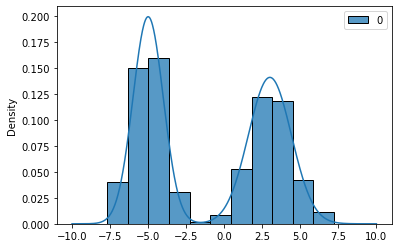

In [83]:
def p(x):
    return 0.5*st.norm.pdf(x, loc=3, scale=sqrt(2)) + 0.5*st.norm.pdf(x, loc=-5, scale=sqrt(1))


def q(x):
    return st.norm.pdf(x, loc=0, scale=sqrt(4))


x = np.linspace(-10, 10, 1000)
M = max(p(x) / q(x))


def rejection_sampling(N, q_dist):
    samples = []
    
    while len(samples) < N:
        z = q_dist.rvs(1)
        u = np.random.uniform(0, 1)

        if u < p(z)/(M*q(z)):
            samples.append(z)

    return np.array(samples)

proposal_dist = st.norm(0, sqrt(4))
samples = rejection_sampling(1000, proposal_dist)

x = np.linspace(-10, 10, 1000)
fig, ax = plt.subplots()
ax.plot(x, 0.5 * st.norm.pdf(x, 3, sqrt(2)) + 0.5 * st.norm.pdf(x, -5, sqrt(1)))
sns.histplot(samples, stat='density', color='r', ax=ax)
fig.show()

As you might have noticed, rejection sampling has two major drawbacks. 

1. It can be difficult to choose a proposal distribution
2. It can be difficult to choose a scaling factor M when we are working with high dimensional random variables. Choosing a sufficiently large M to guarantee a bound on p(x) leads to a small acceptance rate. 

This motivates the need for finding a more efficient approach, which leads us to MCMC sampling algorithms like Metropolis Hastings.  

# Metropolis Hastings

 To make things simple, the code for everything except the sampling algorithms are given. You should review and understand all the given code and make sure the code you write is compatible.

 It might be helpful to first look at some visualizations of how Metropolis Hastings and other sampling algorithms work: [you can explore some here](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=HamiltonianMC&target=banana).


Setting up target distributions: First, we will define three python functions representing our target distributions, which are

- $p_0$: a 2-d multivarate normal (MVN) with independent components,
- $p_1$: a 2-d MVN with highly dependant components, and
- $p_2$: a 2-d mixture of two MVNs.

We have chosen 2-d targets to make it easier to plot the results.

In [84]:
m = np.empty([4,2]); c = np.empty([4,2,2])

m[0] = [0,0]; c[0] = [[1,0],[0,1]]

m[1] = [0,0]; c[1] = 2*np.array([[1,0.98],[.98,1]])


m[2] = [-1,-1]; c[2] = [[.7,.3],[.3,.7]]
m[3] = [ 1, 1]; c[3] = [[.7,.3],[.3,.7]]

def p0(th):
    rv = st.multivariate_normal(mean=m[0],cov=c[0])
    grad = np.dot(th,np.linalg.inv(c[0])) # Note how the gradient is computed
    return [rv.pdf(th),grad]

def p1(th):
    rv = st.multivariate_normal(mean=m[1],cov=c[1])
    grad = np.dot(th,np.linalg.inv(c[1]))
    return [rv.pdf(th),grad]

def p2(th):
    rv1 = st.multivariate_normal(mean=m[2],cov=c[2])
    rv2 = st.multivariate_normal(mean=m[3],cov=c[3])
    return [rv1.pdf(th)+rv2.pdf(th), np.nan]

pp = [p0,p1,p2]

<hr/>
We will plot the mixture target distribution using contourf:

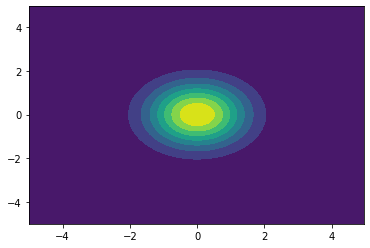

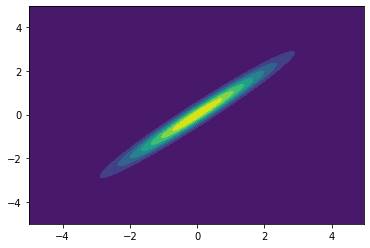

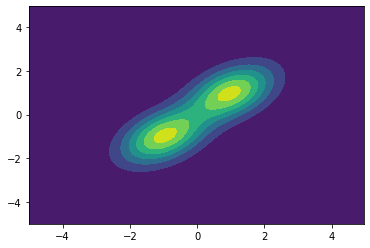

In [85]:
x,y = np.mgrid[-5:5:.05,-5:5:.05]
pos = np.empty(x.shape + (2,)) # the comma ensure (2,) is interpreted as tuple, (2) would be int
pos[:,:,0] = x; pos[:,:,1] = y
for p in pp:
    plt.figure()
    plt.contourf(x,y,p(pos)[0])

**Metropolis Hastings** <br>
To gain a better understanding of the Metropolis Hastings algorithm, we will work through the mathematics behind the method. The detailed balance condition for Markov Chains, written here in another way:
$$ p(x)P(x \rightarrow x') = p(x')P(x' \rightarrow x) \qquad (1)$$ 
Here $p(x)$ is our target distribution and $P(x \rightarrow x')$ is the transition probability of going from $x$ to $x'$. This equation guarantees that our Markov chain will have a stationary distribution. Additionally, if we include ergodicity too (not repeating states at fixed intervals and every state much be able to reach any other state eventually), we will have built a Markov Chain that has a unique stationary distribution, $p(x)$.

We can re-arrange the previous equation as, 
$$ \frac{P(x \rightarrow x')}{P(x' \rightarrow x)} = \frac{p(x')}{p(x)} \qquad (2)$$

Here we use $f(𝑥)$ to represent a function that is proportional to $p(x)$. This is to emphasize that we don't explicitly need $p(x)$, just something proportional to it such that the ratios work out to the same thing. Now the "trick" here is that we're going to break up $P(x \rightarrow x')$ into two independent steps: a proposal distribution $q(x \rightarrow x')$ and an acceptance distribution $A(x \rightarrow x')$ (similar to how rejection sampling works). Since they're independent, our transition probability is just the multiplication of the two:
$$ P(x \rightarrow x') = q(x \rightarrow x') A(x \rightarrow x') \qquad (3)$$

Now, we need to determine what would be an appropriate choice for $q(x)$ and $A(x)$, Since $q(x)$ is the "proposal distribution", it decides the next point we will potentially be sampling. Thus, it's important that it have the same support as our target distribtuion $p(x)$. A typical choice here would be the normal distribution centered on the current state. Now given a fixed proposal distribtuion $q(x)$, we wish to find an $A(x)$ that matches. 
$$ \frac{A(x \rightarrow x')}{A(x' \rightarrow x)} = \frac{p(x')}{p(x)} \frac{q(x' \rightarrow x)}{q(x \rightarrow x')} \qquad (4)$$

Although not obvious, a typical choice for $A(x)$ is 
$$ A(x \rightarrow x') = min(1, \frac{p(x')q(x' \rightarrow x)}{p(x) q(x \rightarrow x')}) \qquad (5)$$

We can see that by considering the cases where $\frac{p(x')q(x' \rightarrow x)}{p(x)q(x \rightarrow x')}$ is less than or equal to 1 and the cases when it is greater than 1. When it's less than or equal to 1, it's inverse is greater than 1, thus the denominator of the LHS, $A(x' \rightarrow x)$, of Equation 4 is 1, while the numerator is equal to the RHS. Alternatively, when $\frac{p(x')q(x' \rightarrow x)}{p(x) q(x \rightarrow x')}$ is greater than one the LHS numerator is 1, while the denominator is just the reciprocal of the RHS, resulting in the LHS equaling the RHS.

With that, we've shown that the steady state of the Markov Chain we've created will be equal to our target distribution (𝑝(𝑥)) because the detailed balance condition is satisfied by construction.

**Pseudocode for Metropolis Hastings** <br>

$\text{initialize } x^{(1)}$ <br>
$\text{for } i = 1 \text{ to } N \text{ do}$ <br>
$\qquad u \sim U(0,1)$ <br>
$\qquad x^* \sim q(x^* | x^{(i)}) $ <br>
$\qquad \text{if } u < min\{ 1, \frac{p(x^{*}) q(x^{(i)}|x^*)}{p(x^{(i)})q(x^* | x^{(i)})} \} \text{ then}$ <br>
$\qquad \qquad x^{(i+1)} \leftarrow x^*$ <br>
$\qquad \text{else}$ <br>
$\qquad \qquad x^{(i+1)} \leftarrow x^{(i)}$ <br>
$\qquad \text{end if}$ <br>
$\text{end for}$

### Q3: Metropolis Hastings
**(3 points)** Implement the Metropolis Hastings sampler with normal jumps. Note that this function has to work with all three distributions

In [86]:
# Implement the Metropolis Hastings sampler
def metropolis(target_p, covJump, init, N_samples):
    
    # covJump: the covariance of the multivariate normal jumping distribution
    # target_p is the target distribution from which we want to sample. this is a function
    N = N_samples ## is the number of samples we want
    th = np.empty((N,len(init))) ## th will hold the samples that we generate
    th[0] = init ## the starting point, i.e., the first sample
    x = init
    
    # TODO Implement Metropolis Hastings here

    for i in range(N-1):
        u = np.random.uniform(0, 1)
        
        x_1 = st.multivariate_normal(mean=x,cov=covJump).rvs(1)
        ratio = target_p(x_1)[0]/(target_p(x))[0]
        if u < min(1,ratio):
            x = x_1
        th[i+1] = x
    return  th

# Comparison of sampled distribution to theoretical distribution:

We now plot the samples obtained MH for four random starting points. You need to run this 3 times to see the result for each of the target distributions. Vary the number of samples and the other parameters values and compare the resulting plots. Below, you will describe the differences between the sampling methods based on this observations in a couple of paragraphs.

### target distribution

# TODO make these plots for i = 0, 1, 2
i = 1
p = pp[i]
N = 1000

# the parameters of the jumping distribution
covJump = np.array([[1,0],[0,1]])
scale = .1

# Metropolis Hastings comparison plots
f, ax = plt.subplots(2,2, sharex='col', sharey='row')

for j in range(2):
    for k in range(2):
        init = st.uniform.rvs(-2,2,2)
        th = metropolis(p, scale*covJump, init, N)
        plt.axes(ax[j][k])
        plt.axis([-3,3,-3,3])
        plt.contourf(x,y,p(pos)[0])
        plt.plot(th[:,0],th[:,1],'k.',alpha=.5)
        # with small number of samples try also ':k.' to see the order of samples


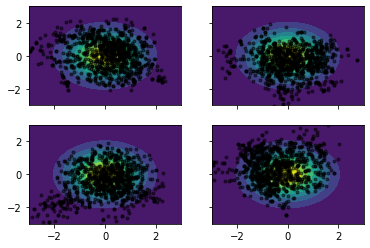

In [87]:
# target distribution

# TODO make these plots for i = 0, 1, 2
i = 0
p = pp[i]
N = 1000

# the parameters of the jumping distribution
covJump = np.array([[1,0],[0,1]])
scale = .1

# Metropolis Hastings comparison plots
f, ax = plt.subplots(2,2, sharex='col', sharey='row')

for j in range(2):
    for k in range(2):
        init = st.uniform.rvs(-2,2,2)
        th = metropolis(p, scale*covJump, init, N)
        plt.axes(ax[j][k])
        plt.axis([-3,3,-3,3])
        plt.contourf(x,y,p(pos)[0])
        plt.plot(th[:,0],th[:,1],'k.',alpha=.5)
        # with small number of samples try also ':k.' to see the order of samples


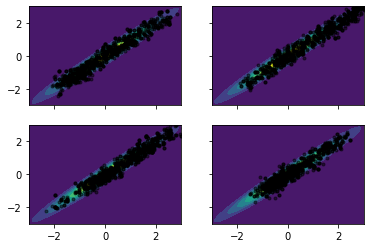

In [88]:
# target distribution

# TODO make these plots for i = 0, 1, 2
i = 1
p = pp[i]
N = 1000

# the parameters of the jumping distribution
covJump = np.array([[1,0],[0,1]])
scale = .1

# Metropolis Hastings comparison plots
f, ax = plt.subplots(2,2, sharex='col', sharey='row')

for j in range(2):
    for k in range(2):
        init = st.uniform.rvs(-2,2,2)
        th = metropolis(p, scale*covJump, init, N)
        plt.axes(ax[j][k])
        plt.axis([-3,3,-3,3])
        plt.contourf(x,y,p(pos)[0])
        plt.plot(th[:,0],th[:,1],'k.',alpha=.5)
        # with small number of samples try also ':k.' to see the order of samples


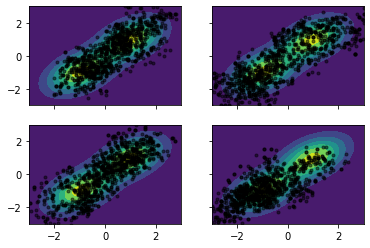

In [89]:
# target distribution

# TODO make these plots for i = 0, 1, 2
i = 2
p = pp[i]
N = 1000

# the parameters of the jumping distribution
covJump = np.array([[1,0],[0,1]])
scale = .1

# Metropolis Hastings comparison plots
f, ax = plt.subplots(2,2, sharex='col', sharey='row')

for j in range(2):
    for k in range(2):
        init = st.uniform.rvs(-2,2,2)
        th = metropolis(p, scale*covJump, init, N)
        plt.axes(ax[j][k])
        plt.axis([-3,3,-3,3])
        plt.contourf(x,y,p(pos)[0])
        plt.plot(th[:,0],th[:,1],'k.',alpha=.5)
        # with small number of samples try also ':k.' to see the order of samples


### Q4: Understanding the sampled MH Distributions

**(3 points)** Using the plots you created with the code above, describe your observations comparing the true distributions to the ones obtained using MH sampling. Specifically, comment on how the parameters of the function leads to changes in the sampled distribution, i.e. changes in the number of samples generated and the covariance of the jump distribution.

Samples in MH distributions clustered in the traget distribution. As the number of samples increases, MH sample distribution get closer to the true distribution. The increase on the covariance of the jump distribution also improves the accuracy on distribution, since sample variance gets smaller.